In [2]:
from ib_insync import *
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
from pykalman import KalmanFilter

In [4]:
util.startLoop()  # only use in interactive environments (i.e. Jupyter Notebooks)
ib = IB()
ib.connect(host='127.0.0.1', port=7497, clientId=1)

<IB connected to 127.0.0.1:7497 clientId=1>

In [5]:
contract = Stock('AAPL','SMART','USD')

data = ib.reqMktData(contract)
display(ib.qualifyContracts(contract)) # must run to fill additional information
print('latest price in RTH is '+str(data.marketPrice())) # only get latest price

historical = ib.reqHistoricalData(
    contract,
    #endDateTime='20210202 23:59:59',
    endDateTime='20210224 23:59:59',
    barSizeSetting='1 min', 
    durationStr='7 D', 
    whatToShow='MIDPOINT', 
    useRTH=True
    )


df = util.df(historical)
df

[Stock(conId=265598, symbol='AAPL', exchange='SMART', primaryExchange='NASDAQ', currency='USD', localSymbol='AAPL', tradingClass='NMS')]

latest price in RTH is nan


,date,open,high,low,close,volume,average,barCount
0,2021-02-16 09:30:00,135.510,135.875,135.375,135.765,-1,-1.0,-1
1,2021-02-16 09:31:00,135.765,135.975,135.645,135.880,-1,-1.0,-1
2,2021-02-16 09:32:00,135.880,136.005,135.285,135.465,-1,-1.0,-1
3,2021-02-16 09:33:00,135.465,135.775,135.370,135.635,-1,-1.0,-1
4,2021-02-16 09:34:00,135.635,135.680,135.265,135.280,-1,-1.0,-1
...,...,...,...,...,...,...,...,...
2725,2021-02-24 15:55:00,125.205,125.425,125.205,125.385,-1,-1.0,-1
2726,2021-02-24 15:56:00,125.385,125.435,125.285,125.435,-1,-1.0,-1
2727,2021-02-24 15:57:00,125.435,125.560,125.435,125.525,-1,-1.0,-1
2728,2021-02-24 15:58:00,125.525,125.525,125.325,125.340,-1,-1.0,-1


In [15]:
df = df['close']
df.sort_index(ascending=True,inplace=True)
df = df.to_frame()
print(df.shape)
df['return'] = df['close'].pct_change() # must not use np.log return diff for FFT
df = df[1:]
sp = np.fft.fft(df['return'].values)
df['theta'] = np.arctan(sp.imag/sp.real) # phase in polar form
df['amplitude'] = np.sqrt(sp.real**2 + sp.imag**2)/(len(df)/2)# we only care about positive absolute amplitude, therefore 1/2
df['freq'] = np.fft.fftfreq(sp.size) # cycles per sample spacing
df

(2724, 1)


,close,return,theta,amplitude,freq
7,134.990,0.000778,1.204806e-16,0.000053,0.000000
8,134.875,-0.000852,5.928512e-02,0.000006,0.000367
9,134.930,0.000408,1.299768e+00,0.000054,0.000734
10,134.800,-0.000963,2.117483e-01,0.000015,0.001102
11,135.040,0.001780,1.036012e+00,0.000009,0.001469
...,...,...,...,...,...
2725,125.385,0.001438,3.966881e-01,0.000059,-0.001836
2726,125.435,0.000399,-1.036012e+00,0.000009,-0.001469
2727,125.525,0.000718,-2.117483e-01,0.000015,-0.001102
2728,125.340,-0.001474,-1.299768e+00,0.000054,-0.000734


Error 1100, reqId -1: Connectivity between IB and Trader Workstation has been lost.
Error 1102, reqId -1: Connectivity between IB and Trader Workstation has been restored - data maintained. All data farms are connected: hfarm; cashfarm; usfuture; jfarm; usfarm.nj; eufarm; usopt; usfarm; euhmds; cashhmds; hkhmds; ushmds; fundfarm; secdefhk.
Error 1100, reqId -1: Connectivity between IB and Trader Workstation has been lost.
Error 1102, reqId -1: Connectivity between IB and Trader Workstation has been restored - data maintained. All data farms are connected: hfarm; cashfarm; usfuture; jfarm; usfarm.nj; eufarm; usopt; usfarm; euhmds; cashhmds; hkhmds; ushmds; fundfarm; secdefhk.
Error 1100, reqId -1: Connectivity between IB and Trader Workstation has been lost.
Error 1102, reqId -1: Connectivity between IB and Trader Workstation has been restored - data maintained. All data farms are connected: hfarm; cashfarm; usfuture; jfarm; usfarm.nj; eufarm; usopt; usfarm; euhmds; cashhmds; hkhmds; us

In [173]:
def std_filter(std_value):
    
    # for the variables can be used outside function
    global regressionDelta
    global regression
    regressionDelta = 0
    regression = 0
    
    #Getting dominant values based on std_value
    meanAmp = df['amplitude'].mean()
    stdAmp = df['amplitude'].std()
    dominantAmpCheck = df['amplitude'] > (std_value*stdAmp + meanAmp)
    positiveFreqCheck = df['freq'] > 0
    dominantAmp = df[dominantAmpCheck & positiveFreqCheck]['amplitude']
    dominantFreq = df[dominantAmpCheck & positiveFreqCheck]['freq']
    dominantTheta = df[dominantAmpCheck & positiveFreqCheck]['theta']

    #Calculating Regression Delta
    for n in range(len(dominantTheta)):
        shift = np.array(dominantTheta)[n]
        regressionDelta += np.array(dominantAmp)[n] * np.cos(n * np.array(range(len(df))) + shift)

    #Converting Delta Time to Time at start value of real data
    startValue = df['close'].values[0]
    regression = startValue + np.cumsum(regressionDelta)

    #Calculating RMSE
    rmse = np.sqrt(np.mean((df['close'].values - regression)**2))

    if np.isnan(rmse):
        rmse = 10000000000000

    # if length of regression being 1 means we did not find any dominant signal    
    if len(regression) > 1:
        return rmse
    else:
        return -1

In [174]:
std_values = []
rmse_values = []

# loop thru and try diff std filter thresholds

for i in np.linspace(0,3,20): # 100 steps, infer step size
    if std_filter(i) != -1:
        rmse_values.append(std_filter(i))
        std_values.append(i)


idx = np.array(rmse_values).argmin()
minSTD = std_values[idx]
print('minSTD is '+str(minSTD))
minRMSE = rmse_values[idx]
print('minRMSE is '+str(minRMSE))

std_filter(minSTD)

df['predict_return'] = regressionDelta
df['predict_price'] = regression
df

minSTD is 0.9473684210526315
minRMSE is 4.719025352252901


,close,return,theta,amplitude,freq,predict_return,predict_price
1,129.130,0.300,-2.526823e-16,0.000601,0.000000,2.551781,131.681781
2,129.220,0.090,-1.424736e+00,0.002789,0.000085,0.068189,131.749971
3,129.450,0.230,1.254478e+00,0.003358,0.000171,-0.070466,131.679505
4,129.255,-0.195,-1.136236e+00,0.003175,0.000256,-0.031835,131.647670
5,129.310,0.055,1.059138e-01,0.003568,0.000342,0.029951,131.677620
...,...,...,...,...,...,...,...
11695,125.385,0.180,1.326992e+00,0.001542,-0.000427,0.017490,134.728176
11696,125.435,0.050,-1.059138e-01,0.003568,-0.000342,0.093783,134.821960
11697,125.525,0.090,1.136236e+00,0.003175,-0.000256,-0.016173,134.805787
11698,125.340,-0.185,-1.254478e+00,0.003358,-0.000171,-0.038550,134.767236


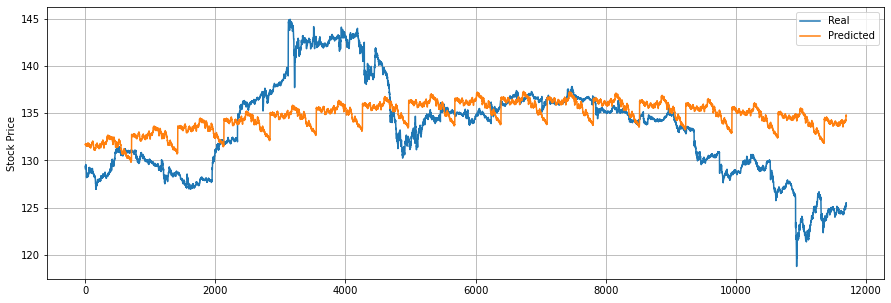

Error 10197, reqId 3: No market data during competing live session, contract: Stock(conId=36285627, symbol='GME', exchange='SMART', primaryExchange='NYSE', currency='USD', localSymbol='GME', tradingClass='GME')
Error 10197, reqId 9: No market data during competing live session, contract: Stock(conId=36285627, symbol='GME', exchange='SMART', primaryExchange='NYSE', currency='USD', localSymbol='GME', tradingClass='GME')
Error 10197, reqId 6: No market data during competing live session, contract: Stock(conId=36285627, symbol='GME', exchange='SMART', primaryExchange='NYSE', currency='USD', localSymbol='GME', tradingClass='GME')
Error 10197, reqId 293: No market data during competing live session, contract: Stock(conId=36285627, symbol='GME', exchange='SMART', primaryExchange='NYSE', currency='USD', localSymbol='GME', tradingClass='GME')
Error 10197, reqId 308: No market data during competing live session, contract: Stock(conId=265598, symbol='AAPL', exchange='SMART', primaryExchange='NASD

In [175]:
plt.figure(figsize=(15,5))
plt.plot(df['close'])
plt.plot(df['predict_price'])
plt.ylabel('Stock Price')
plt.legend(['Real','Predicted'])
plt.grid()